# Genetic Algorithm for EV charging stations

In [1]:
import networkx as nx
import numpy as np
from typing import List, Tuple, Optional

from modules.solvers import GeneticAlgortihm

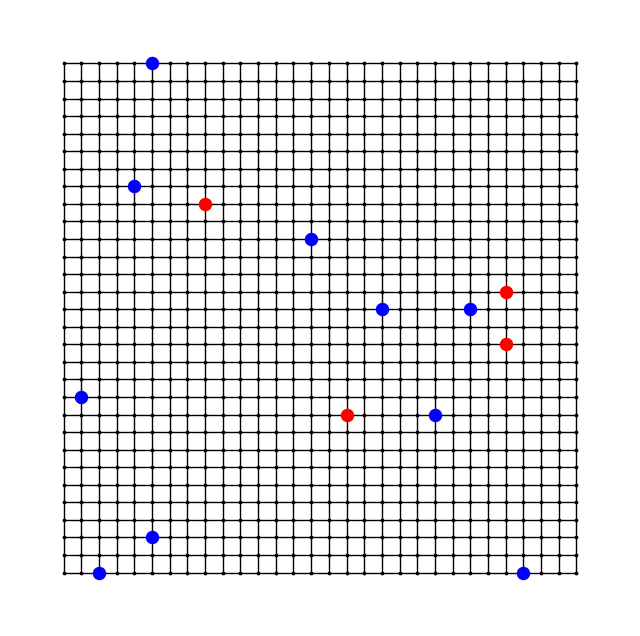

In [2]:
SHAPE = (30, 30)
POI = 10
CHARGERS = 4
NEW_CHARGERS = 6

SEED = "vberb3443"

gen = GeneticAlgortihm(SHAPE, POI, CHARGERS, NEW_CHARGERS, seed=SEED)
gen.draw_grid()

In [3]:
#

61.044939385410416


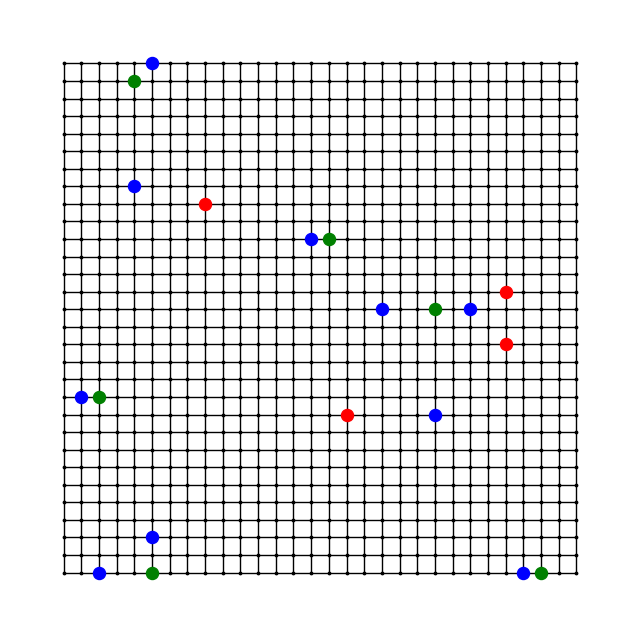

In [7]:
gen.run()
print(gen.best_fitness)
gen.draw_grid()

In [8]:
gen.draw_grid().savefig("readme_imgs/genetic_solution.png")